# Feature Extraction from Audio Chunks (Log-Mel Spectrogram)

In this notebook, I extracted **log-mel spectrogram features** from each 5-second preprocessed chunk (after human voice removal and trimming).

### Why Log-Mel Spectrogram?

The **log-mel spectrogram** captures:
- **Frequency** patterns over time (mel scale approximates human auditory perception)
- **Amplitude dynamics** in a compact form
- Crucial for modeling wildlife sounds and identifying bird vocalizations

### Processing Steps

1. Loaded each `.npz` chunk.
2. Computed mel spectrogram using `librosa.feature.melspectrogram()`.
3. Converted it to decibels using `librosa.power_to_db()`.


### Output

- Features stored as `.npz` files with shape `(64, 313)`.
- Ready-to-use input for both CNN and tabular models.

This step formed the **core representation of bird sounds** used for classification.


In [ ]:
import os
import numpy as np
import librosa

def extract_log_mel_spectrograms(
    chunk_dir='processed/chunks',
    feat_dir='processed/feature',
    n_mels=64,
    n_fft=1024,
    hop_length=512,
    power=2.0,
    verbose=True 
):
    """
    For each .npz in chunk_dir containing 'y' (audio) and 'sr' (sample rate),
    compute a log-mel spectrogram and save it to feat_dir.
    """
    os.makedirs(feat_dir, exist_ok=True)

    for fname in sorted(os.listdir(chunk_dir)):
        if not fname.endswith('.npz'):
            continue

        # Load the chunk
        data = np.load(os.path.join(chunk_dir, fname))
        y, sr = data['y'], int(data['sr'])

        # Compute mel spectrogram (power)
        S = librosa.feature.melspectrogram(
            y=y,
            sr=sr,
            n_fft=n_fft,
            hop_length=hop_length,
            n_mels=n_mels,
            power=power
        )
        # Convert to log scale (dB). Use ref=np.max for relative scaling.
        log_S = librosa.power_to_db(S, ref=np.max)

        # Save as compressed .npz
        out_name = fname.replace('.npz', '_mel.npz')
        out_path = os.path.join(feat_dir, out_name)
        np.savez_compressed(out_path,
                            mel=log_S.astype(np.float32),
                            sr=sr,
                            n_mels=n_mels,
                            n_fft=n_fft,
                            hop_length=hop_length)

        if verbose:
            print(f"Saved {out_name} (shape: {log_S.shape})")

if __name__ == "__main__":
    extract_log_mel_spectrograms()


Saved CSA18786_5_mel.npz (shape: (64, 313))
Saved CSA35130_10_mel.npz (shape: (64, 313))
Saved CSA35130_15_mel.npz (shape: (64, 313))
Saved CSA35130_20_mel.npz (shape: (64, 313))
Saved CSA35130_25_mel.npz (shape: (64, 313))
Saved CSA35130_30_mel.npz (shape: (64, 313))
Saved CSA35130_35_mel.npz (shape: (64, 313))
Saved CSA35130_5_mel.npz (shape: (64, 313))
Saved CSA35146_10_mel.npz (shape: (64, 313))
Saved CSA35146_100_mel.npz (shape: (64, 313))
Saved CSA35146_105_mel.npz (shape: (64, 313))
Saved CSA35146_110_mel.npz (shape: (64, 313))
Saved CSA35146_115_mel.npz (shape: (64, 313))
Saved CSA35146_120_mel.npz (shape: (64, 313))
Saved CSA35146_125_mel.npz (shape: (64, 313))
Saved CSA35146_130_mel.npz (shape: (64, 313))
Saved CSA35146_135_mel.npz (shape: (64, 313))
Saved CSA35146_140_mel.npz (shape: (64, 313))
Saved CSA35146_145_mel.npz (shape: (64, 313))
Saved CSA35146_15_mel.npz (shape: (64, 313))
Saved CSA35146_150_mel.npz (shape: (64, 313))
Saved CSA35146_155_mel.npz (shape: (64, 313))


In [25]:
import numpy as np
import matplotlib.pyplot as plt
import os

def visualize_mel_file(file_path):
    """
    Load and analyze a log-mel spectrogram saved in .npz format.
    Assumes the file contains: 'mel', 'sr', 'hop_length', 'n_mels'.
    """
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return

    # Load .npz
    data = np.load(file_path)
    mel = data['mel']
    sr = int(data['sr'])
    hop_length = int(data['hop_length'])
    n_mels, n_frames = mel.shape
    times = np.arange(n_frames) * hop_length / sr
    freqs = np.linspace(0, sr / 2, n_mels)

    # Print summary
    print(f"File: {os.path.basename(file_path)}")
    print(f"Mel shape: {n_mels} mel bands × {n_frames} frames")
    print(f"Sample rate: {sr} Hz")
    print(f"Hop length: {hop_length} samples → ~{hop_length / sr:.3f} sec/frame")
    print(f"dB range: min={mel.min():.1f}, max={mel.max():.1f}, mean={mel.mean():.1f}, std={mel.std():.1f}")

    # Plot: Heatmap
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(times, freqs, mel, shading='auto', cmap='magma')
    plt.colorbar(label='dB')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title('Log-Mel Spectrogram')
    plt.tight_layout()
    plt.show()

    # Plot: Average energy per band
    plt.figure(figsize=(6, 4))
    avg_band = mel.mean(axis=1)
    plt.plot(freqs, avg_band)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Avg dB')
    plt.title('Average Energy per Mel Band')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot: Histogram of values
    plt.figure(figsize=(6, 4))
    plt.hist(mel.flatten(), bins=50, color='skyblue', edgecolor='black')
    plt.xlabel('dB')
    plt.ylabel('Count')
    plt.title('Distribution of Mel Spectrogram Values')
    plt.tight_layout()
    plt.show()


File: CSA35130_20_mel.npz
Mel shape: 64 mel bands × 313 frames
Sample rate: 32000 Hz
Hop length: 512 samples → ~0.016 sec/frame
dB range: min=-80.0, max=0.0, mean=-43.3, std=10.4


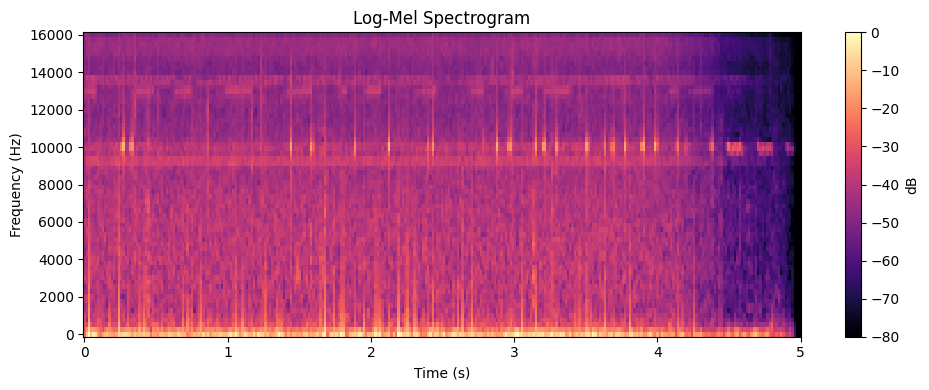

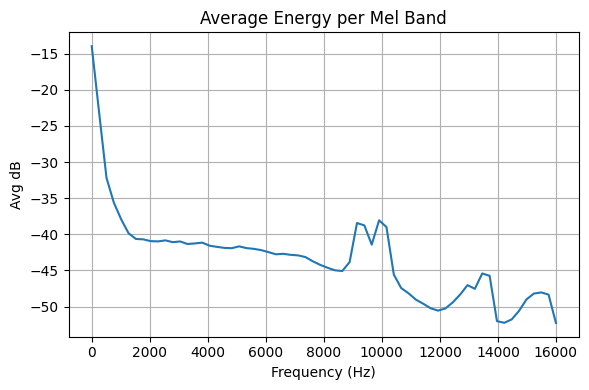

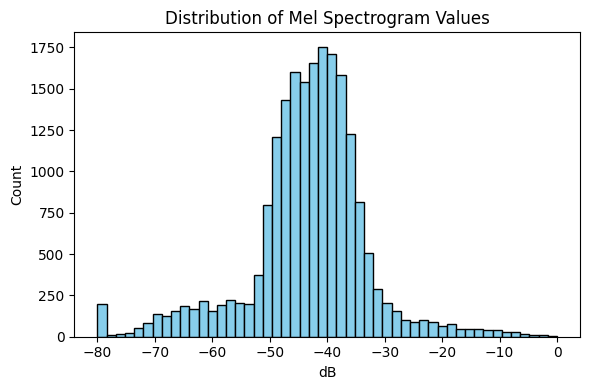

In [42]:
visualize_mel_file("/Users/istiak/Desktop/birdCLEF2025/processed/feature/CSA35130_20_mel.npz")
